# Import Libraries and Set Options

In [1]:
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import collections

from daftpy.daftdata import (get_db)

from daftpy.daftprep import (num_perc, process_price, process_coordinates, drop_coord_outliers, 
                             drop_floor_area, floor_area_wragling, process_floor_area, 
                             drop_info, process_info, process_views, process_rooms)

from daftpy.daftfeanalysis import missing_values

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

# Load Data

We load the information through a fuction which drops the advertiser's personal information. 

In [3]:
sale = get_db(dbname='2021-11-25.db')

In [4]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15391 entries, 0 to 15390
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   daft_id                       15391 non-null  object
 1   item_id                       15391 non-null  object
 2   url                           15391 non-null  object
 3   name                          15391 non-null  object
 4   price                         15391 non-null  object
 5   info                          15391 non-null  object
 6   sale_type                     15391 non-null  object
 7   floor_area                    15391 non-null  object
 8   psr                           15391 non-null  object
 9   ber                           15391 non-null  object
 10  entered_renewed               15391 non-null  object
 11  views                         15391 non-null  object
 12  type_house                    15391 non-null  object
 13  energy_performan

In [5]:
sale.to_csv('../data/01_raw/2021-11-25.csv', sep=',', index=False) 
sale = pd.read_csv('../data/01_raw/2021-11-25.csv', sep=',')
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15391 entries, 0 to 15390
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   daft_id                       15391 non-null  int64 
 1   item_id                       15391 non-null  int64 
 2   url                           15391 non-null  object
 3   name                          15391 non-null  object
 4   price                         15391 non-null  object
 5   info                          15391 non-null  object
 6   sale_type                     15391 non-null  object
 7   floor_area                    15391 non-null  object
 8   psr                           15391 non-null  object
 9   ber                           15322 non-null  object
 10  entered_renewed               15391 non-null  object
 11  views                         15391 non-null  object
 12  type_house                    15391 non-null  object
 13  energy_performan

# Check Missing Values and Duplicates

In [6]:
sale.replace('none', np.nan, inplace=True)

# Check missing values in absolute and relative terms
missing_values(sale)

,Absolute,Relative
daft_id,0,0.000000
item_id,0,0.000000
url,0,0.000000
name,278,0.018063
price,278,0.018063
info,278,0.018063
sale_type,285,0.018517
floor_area,285,0.018517
psr,80,0.005198
ber,3811,0.247612


The feature `energy_performance_indicator` has too many missing values, thus we should beware of them.

|Feature|% missing values|
|:---:|:---:|
|energy_performance_indicator|63|

As it has such a high percentage of missing values and it doesn't appear to be a critical feature we can drop it.

We shouldn't have any duplicated listing thanks to the DuplicatesPipeline implemented in the Scrapy project.

In [7]:
sale.duplicated(keep=False).sum()

0

In [8]:
sale.sample()

,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,energy_performance_indicator,coordinates,type,scraping_date,description
11301,15428496,3430469,https://www.daft.ie/for-sale/site-0-75-acre-si...,"0.75 Acre Site, Ballinagore, Blackwater, Co. W...","€50,000","0.75 ac,Site",For Sale by Private Treaty,0.75 ac,003593,NaN,14/10/2021,"3,949",NaN,NaN,52.45836124979792+-6.3732373757261485,buy,2021-11-25,LOCATION / DESCRIPTION:\r\n\r\nExcellent Circa...


Next, let's start the cleansing and wrangling tasks. We will need cleaned prices and other features if we want to analize them.

# Energy Performance Indicator

We start dropping `energy_performance_indicator` column as we concluded above.

In [9]:
print(f'Before dropping: {sale.shape}')
sale.drop(columns=['energy_performance_indicator'], inplace=True)
print(f'After dropping: {sale.shape}')

Before dropping: (15391, 18)
After dropping: (15391, 17)


# Price

We have strange data points in the column. Let's investigate the different structures we can see:

In [10]:
#sale['price'].value_counts()

In [11]:
# The following are the diferent data point extructures that we can see in 
# the `price` column
sale['price'][[0, 8, 13, 28, 1442, 12842]]

0                         €549,000
8                    AMV: €725,000
13                             NaN
28            Price on Application
1442     AMV: Price on Application
12842          £149,000 (€173,554)
Name: price, dtype: object

**1. Price on Application**

`Price on Application` is the most repeated value in the `price` column. It equates to a 7.63% of ads.

In [12]:
# Ads with `Price on Application` pattern
num_perc(df=sale, 
         feature='price', 
         pattern='Price on Application')

Ads with "Price on Application": 1174
Ads with "Price on Application": 7.63%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
13028,13757752,2908549,https://www.daft.ie/for-sale/detached-house-mo...,"Monivea Village, Monivea, Co. Galway",Price on Application,"3 Bed,1 Bath,139 m²,Detached",For Sale by Private Treaty,139 m²,001860,SI_666,11/10/2021,"7,275",house,53.373768+-8.705481,buy,2021-11-25,Old two-storey farmhouse with outbuildings on ...


We will drop this kind of ads because we can't find out their prices.

**2. AMV: Price on Application**

In [13]:
# Ads with `AMV: Price on Application` pattern
num_perc(df=sale, 
         feature='price', 
         pattern='AMV: Price on Application')

Ads with "AMV: Price on Application": 8
Ads with "AMV: Price on Application": 0.05%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
4085,16782269,3601062,https://www.daft.ie/for-sale/detached-house-ca...,"Carrowkeel, Ballisodare, Co. Sligo",AMV: Price on Application,"3 Bed,1 Bath,101 m²,Detached",For Sale by Public Auction,"Thu, Dec 9th at 12:00 PM",001482,G,18/11/2021,"4,488",house,54.234842+-8.499543,buy,2021-11-25,Prime circa 59.5 acre Residential Farm for sal...


We will drop this kind of ads because we can't find out their prices.

**3. AMV: €725,000**

This patron is repeated a lot of times in the column, we will have to apply wrangling task on them.

**4. NaN**

In [14]:
# Ads with missing values
num_perc(df=sale, 
         feature='price', 
         pattern=np.nan)

Ads with "nan": 278
Ads with "nan": 1.81%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
250,9161897,1443233,https://www.daft.ie/new-home-for-sale/eaton-wa...,NaN,NaN,NaN,NaN,NaN,001314,A3,19/11/2021,"21,712",NaN,53.23770419358395+-6.114693715124645,buy,2021-11-25,All homes in Eaton Way are now sold. \r\n\r\nK...


Advertisements with missing values in the `price` column are 'Development' ads, not 'Houses' ads. Development ads have several houses in it and that is why they have missing values. Furthermore, the houses belonging to developments are already scraped so we should drop the development ads.

In [15]:
# You can check the above statement with the lines of code bellow

# sale[sale['price'].isna()] # Commented for sthetic reasons
sale.loc[sale['price'].isna(), 'url'].sample().values # url to check the ad

array(['https://www.daft.ie/new-home-for-sale/earlsfort-seafield-road-blackrock-co-louth/1118009'],
      dtype=object)

**5. £149,000 (€173,554)**

In [16]:
# Ads with '£' pattern
num_perc(df=sale, 
         feature='price', 
         pattern='£')

Ads with "£": 25
Ads with "£": 0.16%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,coordinates,type,scraping_date,description
3046,16891105,3610164,https://www.daft.ie/for-sale/detached-house-4-...,"4 Old Chapel Road, Aughnacloy, Co. Tyrone","£285,000 (€331,966)","4 Bed,2 Bath,Detached",For Sale by Private Treaty,For Sale by Private Treaty,002115,NaN,15/11/2021,246,house,54.4287416+-6.9930307,buy,2021-11-25,This sale represents a fantastic opportunity t...


Ads with prices in pounds are usually from North Ireland, which belongs to United Kingdom so we will drop these ads.

In [17]:
# You can check the above statement with the lines of code bellow

# sale.dropna(subset=['price']).loc[
 #    sale.dropna(subset=['price'])['price'].str.contains('£')] # Commented for sthetic reasons

sale.dropna(subset=['price']).loc[
    sale.dropna(subset=['price'])['price'].str.contains('£'), 'url'
                                 ].sample().values # url to check the ad

array(['https://www.daft.ie/for-sale/detached-house-shandragh-knockans-rathlin-island-ballycastle-co-antrim/2731545'],
      dtype=object)

**-> Conclusion**

Wrangling and cleansing tasks: 

|Value structure in ad's price|Number of ads|Percentage of ads|Task|
|:---:|:---:|:---:|:---:|
|€549,000|||Wrangling|
|AMV: €725,000|||Wrangling|
|£149,000 (€173,554)|25|0.16%|Drop|
|Price on Application|1174|7.63%|Drop|
|AMV: Price on Application|8|0.05%|Drop|
|NaN|278|1.81%|Drop|

Let's compare the before and after of transformations.

In [18]:
pd.DataFrame({'before': sale['price'], 
              'after': process_price(sale)['price']}).head(10)

Rows before dropping: 15391
Rows after dropping: 13906
----------
Difference: -1485


,before,after
0,"€549,000",549000.0
1,"€220,000",220000.0
2,"€495,000",495000.0
3,"€350,000",350000.0
4,"€450,000",450000.0
5,"€365,000",365000.0
6,"€325,000",325000.0
7,"€550,000",550000.0
8,"AMV: €725,000",725000.0
9,"€325,000",325000.0


Let's do it!

In [19]:
sale = process_price(sale.copy()).reset_index(drop=True)

Rows before dropping: 15391
Rows after dropping: 13906
----------
Difference: -1485


# Coordinates

There are no missing values in the coordinates columns and the structure is the same in all data points. We will use the `process_coordinates` to make one new column for `latitude` and another one for `longitude`. The function also drops the `coordinates` column once it has been processed.

In [20]:
# Same structure in all data points in the column
sale['coordinates'].sample()

8872    54.0208+-7.833467
Name: coordinates, dtype: object

As the structure is the same in all ads, we can split the `coordinates` column in `+` using vectorized operations and create new columns from that. 

In [21]:
sale = process_coordinates(sale)

Shape before process: (13906, 17)
Shape after process: (13906, 18)


We can use the new columns to make a scatter plot in order to check whether the points show a similar form that Ireland.

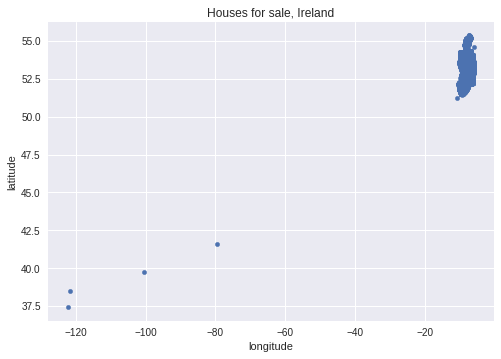

In [22]:
# Check coordinates outliers 
sale.plot(kind='scatter', x='longitude', y='latitude', title='Houses for sale, Ireland');

As you can see above, there are some isolated points with a lower `latitude` that make it difficult to visualizate any country so the right thing would be drop them.

In [23]:
# Drops coordinates outliers
sale = drop_coord_outliers(sale)

Rows before dropping: 13906
Rows after dropping: 13899
----------
Difference: -7


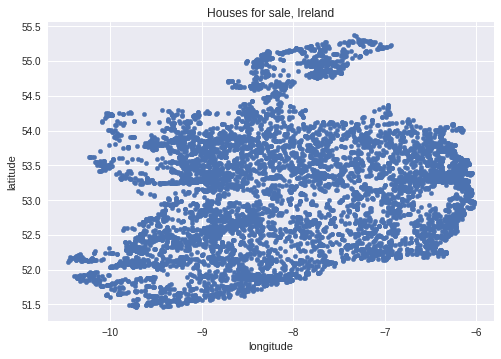

In [24]:
sale.plot(kind='scatter', x='longitude', y='latitude', title='Houses for sale, Ireland'); # esta un poco achatada pero es Irlanda

# Floor Area

The most common pattern in the `floor_area` column follows a structure like this: `177 m²`. Nevertheless, there are several patterns that we will need to hand.

In [25]:
#sale['floor_area'].sample(30)

In [26]:
# The following are the diferent data point extructures that we can see in 
# the `price` column
sale['floor_area'][[1861, 12076, 10284, 5114]]

1861     For Sale by Public Auction
12076                       0.65 ac
10284    For Sale by Private Treaty
5114                         267 m²
Name: floor_area, dtype: object

**1. m²**

`floor_area` is a promising predictor but only a 55% of ads show this information. We will drop the other values but let's explore ads which `floor_area` is mesured in `acres` to check if we can conserve them.

In [27]:
# Ads with 'm²' pattern
num_perc(df=sale, 
         feature='floor_area', 
         pattern='m²')

Ads with "m²": 7757
Ads with "m²": 55.81%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,type,scraping_date,description,latitude,longitude
8089,16161219,3534326,https://www.daft.ie/for-sale/bungalow-cappanal...,"Cappanalosset, Ballinahowen",340000.0,"4 Bed,2 Bath,178 m²,Bungalow",For Sale by Private Treaty,178 m²,003808,F,01/11/2021,"3,495",NaN,buy,2021-11-25,Features\r\n\r\n- Constructed in 2009\r\n- Sol...,53.329981,-7.758804


**2. ac**

In [28]:
# Ads with 'ac' pattern
num_perc(df=sale, 
         feature='floor_area', 
         pattern='ac')

Ads with "ac": 2540
Ads with "ac": 18.27%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,type,scraping_date,description,latitude,longitude
5453,16531540,3577533,https://www.daft.ie/for-sale/site-the-downs-mu...,"The Downs, Mullingar, Co. Westmeath",120000.0,"0.5 ac,Site",For Sale by Private Treaty,0.5 ac,001440,NaN,14/10/2021,823,NaN,buy,2021-11-25,"Half acre site approx. situated in the downs, ...",53.506894,-7.243538


If we check some ads we will see that ads with `ac` pattern refer to land extensions so we will drop them as well as the other ads with different patterns.

In [29]:
sale.dropna(subset=['floor_area']).loc[
    sale.dropna(subset=['floor_area'])['floor_area'].str.contains('ac'), 'url'
                                 ].sample().values # url to check the ad

array(['https://www.daft.ie/for-sale/site-newcastle-athenry-co-galway/3599279'],
      dtype=object)

**3. NaN**

There are just two missing values becaouse we dropped almost all of them when we dropped the ads with `NaN` values in the `price` column.

In [30]:
# Ads with 'NaN' pattern
num_perc(df=sale, 
         feature='floor_area', 
         pattern=np.nan)

Ads with "nan": 2
Ads with "nan": 0.01%


,daft_id,item_id,url,name,price,info,sale_type,floor_area,psr,ber,entered_renewed,views,type_house,type,scraping_date,description,latitude,longitude
1358,17007982,3623069,https://www.daft.ie/for-sale/bungalow-sragh-ro...,"Sragh Road, Tullamore, Co. Offaly",385000.0,"4 Bed,1 Bath,Bungalow",NaN,NaN,003314,C3,24/11/2021,"1,319",NaN,buy,2021-11-25,This 4 bedroom detached bungalow is situated o...,53.281,-7.513493


**-> Conclusions**

Wrangling and cleansing tasks: 

|Value structure in ad's price|Number of ads|Percentage of ads|Task|
|:---:|:---:|:---:|:---:|
|756 m²|7757|55.81%|Wrangling|
|2 ac|2540|18.27%|Drop|
|NaN|2|0.01%|Drop|
|For Sale by Private Treaty|||Drop|
|Section 27|||Drop|
|Thu, Nov 25th at 12:00 PM|||Drop|

Let's compare the before and after of transformations.

In [31]:
pd.DataFrame({'before': sale.dropna(subset=['floor_area'])['floor_area'], 
              'after': process_floor_area(sale)['floor_area']}).head(10)

Rows after dropping: 13899
Rows after dropping: 7757
----------
Difference: -6142


,before,after
0,253 m²,253
1,For Sale by Private Treaty,NaN
2,165 m²,165
3,131 m²,131
4,188 m²,188
5,For Sale by Private Treaty,NaN
6,73 m²,73
7,111 m²,111
8,The Leinster Property Auctions,NaN
9,192 m²,192


The following function helps us dropping all rows that do not contain the pattern `m²` as well as those whit misiing values. Furthermore, it will wrang the column to let us analyse the data in the next notebook.

In [32]:
sale = process_floor_area(sale)

Rows after dropping: 13899
Rows after dropping: 7757
----------
Difference: -6142


# Info

If we look at the info example we can see four variables into the same column, so it would be a good idea to split them in different columns.

In [33]:
sale[['info', 'floor_area']].sample(5)

,info,floor_area
2072,"11 Bed,8 Bath,465 m²,Detached",465
9275,"3 Bed,3 Bath,106 m²,Terrace",106
10905,"5 Bed,7 Bath,226 m²,Detached",226
5822,"5 Bed,4 Bath,90 m²,Semi-D",90
100,"3 Bed,3 Bath,108 m²,Detached",108


Also, we can see that there is no more missing values in the `info` column by the moment.

In [34]:
sale['info'].isna().sum()

0

Let's check the possible data point's length after been splitted by `,`:

In [35]:
# Create a DataFrame with the number of values with different lengths
pd.DataFrame({'Absolute': sale['info'].str.split(',').apply(len).value_counts(), 
              'Relative': sale['info'].str.split(',').apply(len).value_counts() / sale.shape[0]})

,Absolute,Relative
4,7662,0.987753
3,81,0.010442
2,14,0.001805


Let's dig a little deeper into the different cases.

**1. Length = 2**

Ads with splitted `info` length equal to two usually forget both the number of bedrooms and bathrooms.

In [36]:
# Splitted `info` length = 2
#sale.dropna(subset=['info']).loc[sale['info'].dropna().str.split(',').apply(len) == 2, ['info', 'floor_area']].sample(5) 
sale.loc[sale['info'].str.split(',').apply(len) == 2, ['info', 'floor_area']].sample(5) 

,info,floor_area
10998,"30 m²,Studio",30
2707,"223 m²,Detached",223
8355,"2023 m²,Detached",2023
6924,"3035 m²,Detached",3035
95,"99 m²,Terrace",99


**2. Length = 3**

If we check the rows that have a splitted `info` length of three we will see the following pattern where the advertiser forgot to add the number of bathrooms or the number of bedrooms. Usually he forgot the number of bathrooms.

In [37]:
sale.loc[(sale['info'].str.split(',').apply(len) == 3), ['info', 'floor_area']].head()

,info,floor_area
265,"3 Bed,90 m²,Semi-D",90
383,"2 Bed,79 m²,Apartment",79
984,"2 Bed,64 m²,Terrace",64
987,"4 Bed,173 m²,Terrace",173
1390,"6 Bed,190 m²,End of Terrace",190


**-> Conclusions**

As rows that forget one or two values are so few we can drop them instead filling the lack of information.  

We will split the other ones into three columns as we already have the floor area.

Wrangling and cleansing tasks: 

|Value structure in ad's price|Number of ads|Percentage of ads|Task|
|:---:|:---:|:---:|:---:|
|4|7662|0.98|Wrangling: Split into 3 columns|
|3|81|0.01|Drop|
|2|14|0.001|Drop|

So let's do it! We will use a fuction to drop those rows which have a splitted `info` length less than four and to split the other ones into three new columns as well as dropping the `info` column.

In [38]:
sale = process_info(sale)

Shape before dropping: (7757, 18)
Shape after dropping: (7662, 18)
----------
Dropped: 95 rows

Shape before splitting: (7662, 18)
Shape after splitting: (7662, 20)
----------
Difference: 2 columns


# Views

In [39]:
sale[['views']].sample(3)

,views
2373,"2,230"
5033,"5,209"
3419,"14,972"


The only wrangling task we have to apply in the `views` column is to quit the comma. We have a simple function for that. 

In [40]:
sale = process_views(sale)

# Bedroom and Bathroom

The only wrangling task we need to apply on `bedroom` and `bathroom` columns is to isolate the number and to erase the word.

In [41]:
sale[['bedroom']].sample(3)

,bedroom
2766,4 Bed
2879,3 Bed
8040,2 Bed


In [42]:
sale[['bathroom']].sample(3)

,bathroom
10587,1 Bath
7786,1 Bath
8021,1 Bath


Of course we have a simple and amazing function prepared to do that.

In [43]:
sale = process_rooms(sale)

In [44]:
sale[['bedroom', 'bathroom']].sample(3)

,bedroom,bathroom
1935,3,3
11296,4,3
5750,1,1


# Ber and Type House

METER EXPLICACION Y FOTO BER

`ber` and `type_house` columns don't need wrangling tasks as we extracted them pretty well thanks to Scrapy.

However, both columns contain aroun a 25% of missing values each one. We will leave them as they are for now.

# PSR

The Register identifies licensed property service providers by name, number, licence type and location. This column doesn't seem too interesting but we will keep it for now.

You can find more information about PSR Licence Number [here](http://www.psr.ie/en/PSRA/Pages/Register_Licensed_PSP).

In [45]:
sale['psr'].sample(3)

6780     004302
13463    002897
1668     001848
Name: psr, dtype: object

# Description

Esto tengo que mirarlo cuando ya tenga algo presentable.

In [46]:
sale['description'].sample().values

array(['This wonderful bungalow is situated at Elderwood, a quality-built development at Castlebridge. On arrival to the development this detached bungalow is on the first left with only 3 dwellings, offering a very private cul-de-sac with ample parking.Â\xa0 It is within walking distance of all amenities including church, school, pharmacy, restaurant, pubs, etc.Â\xa0 There is also an excellent childcare facility situated within the Elderwood development.Â\xa0 No. 90 comes to the market in pristine condition.Â\xa0 It has spacious and light-filled accommodation, with dual side access and large south-westerly facing garden to the rear.\n\nThe gardens themselves are laid out in lawn, are safe and enclosed, ideal for children.Â\xa0 There is parking to the front for several cars.Â\xa0 If you are looking for a home within 5 minutes€TMdrive of both Wexford town and a choice of some superb sandy beaches, this must be viewed.\n\nViewing is strictly by prior appointment with the sole selling age

# Other columns

Now it is a good moment to check missing values and remenber the other columns the DataFrame contais.

In [47]:
# Check missing values in absolute and relative terms
missing_values(sale)

,Absolute,Relative
daft_id,0,0.000000
item_id,0,0.000000
url,0,0.000000
name,0,0.000000
price,0,0.000000
sale_type,0,0.000000
floor_area,0,0.000000
psr,16,0.002088
ber,195,0.025450
entered_renewed,0,0.000000


### Daft.ie, Item.ie, url, Name

These four columns don't seem very useful in order to infer houses prices. However, we should keep some of them for several reasons. 

- `daft_id`: This is the ad identifier provided by the website.
- `item_id`: After know that the website provides an identifier I bilt one so now it is completely useless. This identifier was extracted from the ad's url.
- `url`: The url could be useful as an indentifier but I prefer to give that task to the `daft.ie` column. The url will be saved just in case we need to check some advertisements.
- `name`: It can't be used as an idetifier because is possible to have some of them repeated. We will keep it because it could provide some information, but a priori I don't think we will use it.

|Column|What to do?|
|:---:|:---:|
|daft.ie|Keep|
|item.ie|Drop|
|url|Keep|
|name|Keep|

In [48]:
sale.drop(columns='item_id', inplace=True)

### Sale Type

Esto tengo que mirarlo cuando ya tenga algo presentable.

In [49]:
sale['sale_type'].value_counts()

For Sale by Private Treaty                7561
1 units available in this development       22
For Sale by Public Auction                  17
2 units available in this development        9
6 units available in this development        8
4 units available in this development        7
5 units available in this development        7
10 units available in this development       7
3 units available in this development        5
8 units available in this development        3
For Sale by Private Tender                   3
7 units available in this development        2
16 units available in this development       2
For Sale by Public Tender                    2
20 units available in this development       1
26 units available in this development       1
12 units available in this development       1
9 units available in this development        1
13 units available in this development       1
88 m²                                        1
111 m²                                       1
Name: sale_ty

### Entered-Renewed

`entered_renewed` is the date that the ad was entered or renewed. It doesn't need wrangling task but we could convert it to a datetime type. We will do that later in another notebook.

In [50]:
sale['entered_renewed'].sample(3)

2260    15/11/2021
6543    18/10/2021
7625    25/11/2021
Name: entered_renewed, dtype: object

### Type

This column show whether the ad is for sale or for rent. There are houses and rooms for rent in the other table of the database.

In [51]:
sale['type'].value_counts()

buy    7662
Name: type, dtype: int64

### scraping_date

In [52]:
sale['scraping_date'].value_counts()

2021-11-25    7662
Name: scraping_date, dtype: int64

# Save Data

In [53]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7662 entries, 0 to 13881
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   daft_id          7662 non-null   int64  
 1   url              7662 non-null   object 
 2   name             7662 non-null   object 
 3   price            7662 non-null   float64
 4   sale_type        7662 non-null   object 
 5   floor_area       7662 non-null   object 
 6   psr              7646 non-null   object 
 7   ber              7467 non-null   object 
 8   entered_renewed  7662 non-null   object 
 9   views            7662 non-null   float64
 10  type_house       7175 non-null   object 
 11  type             7662 non-null   object 
 12  scraping_date    7662 non-null   object 
 13  description      7661 non-null   object 
 14  latitude         7662 non-null   float64
 15  longitude        7662 non-null   float64
 16  bedroom          7662 non-null   object 
 17  bathroom     

In [54]:
sale.to_csv('data/sale_cleaned.csv', sep=',', index=False) # False